<a href="https://colab.research.google.com/github/hadicaksono/Portofolio-DataScience-Hadi/blob/main/customer_segmentation_clustering_e_commerce_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hadicaksono","key":"d4107d06292915fc067109ce03fa2ecf"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carrie1/ecommerce-data

Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
ecommerce-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip ecommerce-data.zip

Archive:  ecommerce-data.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data.csv                


In [ ]:
import pandas as pd
df = pd.read_csv("data.csv", encoding='latin1')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype('int') # type konsisten

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM

In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                    # Frequency
    'TotalAmount': 'sum'                                     # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,2,182,4310.00
2,12348,75,31,1797.24
3,12349,19,73,1757.55
4,12350,310,17,334.40


Tujuan RFM untuk pengelompokan tiap customer dari 1 s.d 3 ke dalam metrik
*   1 = Buruk
*   2 = Sedang
*   3 = Bagus




In [ ]:
rfm['R_score'] = pd.qcut(rfm['Recency'], q=3, labels=[3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'], q=3, labels=[1,2,3])
rfm['M_score'] = pd.qcut(rfm['Monetary'], q=3, labels=[1,2,3])


In [ ]:
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

In [ ]:
rfm[['CustomerID','Recency','Frequency', 'Monetary','R_score','F_score','M_score']].head(10)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score
0,12346,326,2,0.00,1,1,1
1,12347,2,182,4310.00,3,3,3
2,12348,75,31,1797.24,2,2,3
3,12349,19,73,1757.55,3,2,3
4,12350,310,17,334.40,1,1,1
5,12352,36,95,1545.41,2,3,3
6,12353,204,4,89.00,1,1,1
7,12354,232,58,1079.40,1,2,2
8,12355,214,13,459.40,1,1,2
9,12356,23,59,2811.43,3,2,3


In [ ]:
from sklearn.preprocessing import StandardScaler

# Gunakan Kolom RFM asli
rfm_scaled = rfm[['Recency','Frequency','Monetary']]

# Standarisasi
scaler= StandardScaler()
rfm_scaled_values = scaler.fit_transform(rfm_scaled)

# Konversi ke DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled_values,
                             index= rfm['CustomerID'],
                             columns=['Recency','Frequency','Monetary'])
rfm_scaled_df.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12346,2.322023,-0.391720,-0.231001
12347,-0.893733,0.382657,0.293432
12348,-0.169196,-0.266959,-0.012316
12349,-0.725005,-0.086271,-0.017146
12350,2.163220,-0.327188,-0.190312
12352,-0.556277,0.008375,-0.042958
12353,1.111152,-0.383116,-0.220172
12354,1.389057,-0.150803,-0.099662
12355,1.210403,-0.344397,-0.175102


# Clustering KMeans

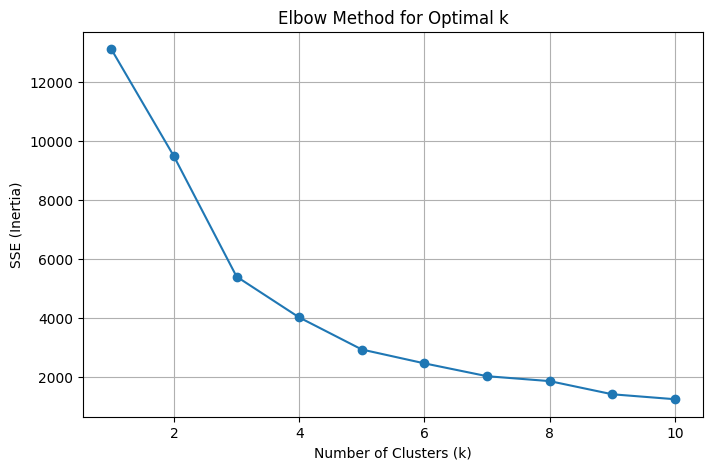

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse= []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(rfm_scaled_df)
  sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11),sse,marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Contoh penerapan jika k = 4

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

rfm[['CustomerID', 'RFM_Score', 'Cluster']].head(10)

,CustomerID,RFM_Score,Cluster
0,12346,3,1
1,12347,9,0
2,12348,7,0
3,12349,8,0
4,12350,3,1
5,12352,8,0
6,12353,3,1
7,12354,5,1
8,12355,4,1
9,12356,8,0


# Visualisasi Clustering PCA

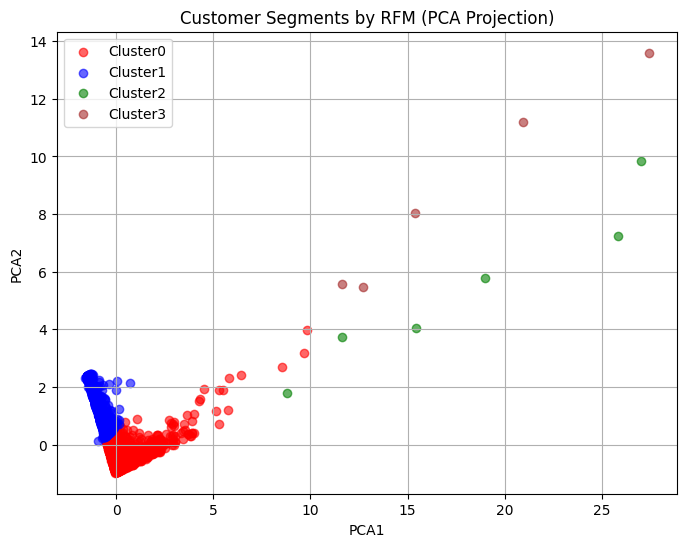

In [ ]:
from sklearn.decomposition import PCA

# Reduksi dimensi ke 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled_df)

rfm['PCA1'] = pca_result[:,0]
rfm['PCA2'] = pca_result[:,1]

# Plot Cluster

plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green','brown']

for i in range(k):
  plt.scatter(
      rfm[rfm['Cluster'] == i]['PCA1'],
      rfm[rfm['Cluster'] == i]['PCA2'],
      label=f'Cluster{i}',
      alpha=0.6,
      color=colors[i]
  )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Customer Segments by RFM (PCA Projection)')
plt.legend()
plt.grid(True)
plt.show()

**Karakteristik tiap cluster**

In [ ]:
label_map = {
    0: 'Loyal Big Spenders',
    1: 'At Risk/Churn',
    2: 'Recent VIP',
    3: 'Potential Loyalists'
    }
rfm['Cluster_Label'] = rfm['Cluster'].map(label_map)

In [ ]:
cluster_summary= rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
cluster_summary['Customer Count'] = rfm['Cluster'].value_counts().sort_index()
cluster_summary = cluster_summary.merge(rfm[['Cluster', 'Cluster_Label']].drop_duplicates(), on='Cluster')
cluster_summary

,Cluster,Recency,Frequency,Monetary,Customer Count,Cluster_Label
0,0,40.03,105.03,1994.06,3258,Loyal Big Spenders
1,1,246.57,27.77,464.79,1103,At Risk/Churn
2,2,1.67,4821.50,55039.93,6,Recent VIP
3,3,9.00,1013.40,192103.85,5,Potential Loyalists
